In [71]:
import pandas as pd
import numpy as np
import os as os
from copy import copy

pd.set_option('display.max_columns', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [72]:
# read in data table

# # baseline condition
# cond = 'BL'
# outDir = 'FeatSeenBySubBaseline/'
# outDirIdeal = 'FeatIdealBL/'
# f = '../allFixTable_KARS_Base.txt'
# labInd = [False]*52

# # label conditione
# cond = 'Label'
# outDir = 'FeatSeenBySubLabel/'
# outDirIdeal = 'FeatIdealLabel/'
# f = '../allFixTable_KARS_Lab.txt'
# labInd = [ True]*12 + [True, True, False, False, True,True,False,False, True,True,False,False]*3

# diff reinforcement supervised condition
cond = 'Sup'
outDir = 'FeatSeenBySubSup/'
outDirIdeal = 'FeatIdealSup/'
f = '../allFixTable_KARS_SUP.txt'
labInd = [ True]*12 + [True, True, False, False, True,True,False,False, True,True,False,False]*3

# # ADULT baseline condition
# cond = 'AdultBL'
# outDir = 'FeatSeenBySubAdultBL/'
# outDirIdeal = 'FeatIdealAdultBL/'
# f = '../allFixTable_KARS_AdultBase.txt'
# labInd = [False]*52

# # ADULT SUPervised condition
# cond = 'AdultSUP'
# outDir = 'FeatSeenBySubAdultSUP/'
# outDirIdeal = 'FeatIdealAdultSUP/'
# f = '../allFixTable_KARS_AdultSup.txt'
# labInd = [ True]*12 + [True, True, False, False, True,True,False,False, True,True,False,False]*3



# df = pd.read_pickle( 'dfBehavKARSAll.p')  
df = pd.read_csv( f, sep='\t',low_memory=False )
#df

In [73]:
df.columns

Index([u'breakIndicator', u'trial', u'loomvid', u'loomimg', u'engager',
       u'goleft', u'sound', u'break_vid_num', u'look_loc', u'look_rt', u'acc',
       u'soundPlayed', u'subId', u'fixX', u'fixY', u'pupil', u'fixDuration',
       u'fixStart', u'fixEnd', u'sacEndPosX', u'sacEndPosY', u'sacStartPosX',
       u'sacStartPosY', u'sacStartTime', u'sacEndTime', u'sacVel',
       u'sacDuration', u'sacAmp', u'fixAois', u'sacAois', u'lastMessage'],
      dtype='object')

In [74]:
# keep only fixations at background image.  Kick out saccade data
# df.drop(['sacEndPosX','sacEndPosY','sacStartPosX', 'sacStartPosY','sacStartTime','sacEndTime','sacVel', 'sacDuration','sacAmp','sacAois'], axis=1, inplace=True)
# df.drop(['loomimg'], axis=1, inplace=True)
df = df[['subId','trial','loomvid','fixDuration','fixAois','pupil','lastMessage', 'acc','look_loc','look_rt', 'fixX', 'fixY', 'fixStart', 'fixEnd', 'sacEndPosX', 'sacEndPosY', 'sacStartPosX', 'sacStartPosY', 'sacStartTime', 'sacEndTime', 'sacVel']] 





In [75]:
# df.columns .sort()
# df.fixAois.values
# df
# dfAnon

In [76]:
# map the fixAOIs to the feature index  (in that direction)
aoiDict= {'1':1, '2':2, '3':4, '4':7, '5':4, '6':6, '7':5, '-1':np.nan,'8':np.nan, np.nan:np.nan  }
'''
            AOI ->  fileNameIndex
     ----------------------
    antenna 1 -> 1
    mouth   2 -> 2
    hand    3 -> 4
    back/body 4-> 7  ( back actually fileNameIndex 3, and ignored. Using just index 7 for the body feature)    
    hand    5 -> 4
    tail    6 -> 6 
    feet    7 -> 5
    
'''


# get feature vector name (loomvid)
df['featVect'] = df.loomvid.apply(lambda(x): x.split('_')[2] )
df.drop( 'loomvid', axis=1, inplace=True)

# tag the extra features to it
catLabTag = { 'R':'00B','Q':'11A' } # add color, label, catLetter for figure drawing (A/B)
df['longFeatVect'] = df.featVect.apply( lambda(x): x[1:]+catLabTag[x[0]])
df = df.reset_index()

# note if they are labeled trials
df['isLabeled'] = df.trial.apply(lambda(x):labInd[x-1] )

# set to NAN when participants did not make response
df.ix[df.look_rt ==-1,'acc' ] = np.nan
df.ix[df.look_rt ==-1,'look_rt' ] = np.nan
df.ix[df.look_rt ==-1,'look_loc' ] = np.nan
df.drop( 'index', axis=1, inplace=True)

# convert fixation AOS to name feature index 
df.ix[df.fixAois.isnull(),'fixAois'] = -1  # make non fixations -1 to make nans for name feature
df['nameFeatIdx' ] = df.fixAois.apply( lambda(x): aoiDict[str(int(x))] )


#output anonymized raw data
# anonymize
dfAnon = df.copy()
count = 0
for s in dfAnon.subId.unique():
    count+= 1
    dfAnon.ix[dfAnon.subId==s ,'subId'] = ('sub%d'% count)
dfAnon.to_csv( 'KARSGaze_Anon' + cond + '.txt', sep=',', index=False)   



#----------------
# get the trial information, for idealized analysis not considering where participant looking
dfIdeal = df.groupby( ['subId','trial'], as_index=False).head(1).reset_index().drop('index', axis=1)

#-----------------

# get just for during the static background (most analysis based on this)
df = df[ df.lastMessage == 'BackgroundFrame']
df = df[ df.fixAois.notnull()]  # remove non-AOI fixations
df = df[ df.nameFeatIdx.notnull()] # drop non-feature looks







In [77]:
# df
# dfAnon

# dfIdeal

#.reset_index() #.drop('index', inplace=True)

In [78]:
# save a csv text file for each participant based on what they saw on each trial, as well as accuracy


def mkSOMTable( df, outDir, removeLabeled = False, useGaze = True):
    ''' this makes a csv table of feature values for every exemplar seen by participants during the study.
        If useGaze == False, then it will return all the features without setting to 0.5 those not fixated.
        if removeLabeled == True, will omit trials that were labeled (not test trials)
    '''
    if not os.path.exists( outDir):
        os.mkdir(outDir)

    # go through every subject and trial, make a by subject  feature matrix
    cols = ['Antenna','Mouth','Back','Hand','Feet','Tail','Body','Color','Label', 'category', 'accuracy', 'isLabeled']

    for s in df.subId.unique():
        # to store all feature vectors seen for a participant
        subFeats = []

        f = open( outDir+s+'.csv', 'w')
        f.write( ','.join(cols) + '\n' )
        for t in df[ df.subId ==s].trial.unique():
            tr = df[(df.subId ==s) & (df.trial ==t)  ]

            
            # get unseen features            
            if useGaze:
                missed = range(1,8)
                missed = [ x for x in missed if x not in tr.nameFeatIdx.unique()]
            else:
                missed = []
                
            # make the unseen ones .5 in long feature vector
            longFeat = list(tr.longFeatVect.iloc[0])
            for m in missed:
                longFeat[m-1] = '0.5'
            longFeat = ','.join(longFeat) #.split(',')
            if removeLabeled:
                if tr.isLabeled.iloc[0]: # if trial labeled
                    acc= np.nan
                else:
                    acc = tr.acc.iloc[0]
            else:
                acc = tr.acc.iloc[0]

            f.write( longFeat +',' + str(acc) + ',' + str(tr.isLabeled.iloc[0]) +'\n')  #features and accuracy
    #         subFeats.append(longFeat)
        f.close()

#------------------------------------

mkSOMTable( df, outDir, removeLabeled = False, useGaze = True)
mkSOMTable( dfIdeal, outDirIdeal, removeLabeled = False, useGaze =False)
        
        
    # make and export dataframe    
#     subDF = pd.DataFrame( subFeats, columns=cols)  
#     subDF.to_csv( outDir+s+'.csv',sep=',', index=False )
    
  

In [79]:
str(np.nan)

'nan'

In [80]:
# get histogram of where participants look, and their corresponding accuracy on the experiment

N = df.subId.unique().shape[0]
lookList = np.zeros( (N,7))  *np.nan  #  where looked
accList = np.zeros( N) * np.nan       # accuracy

for idx,s in enumerate(df.subId.unique()):
    sub = df[ df.subId == s]
    #     h = sub.nameFeatIdx.value_counts()
    lookList[idx,:], bins = np.histogram( sub.nameFeatIdx, bins=np.arange(1,9,1), normed=True)
    accList[idx] = nanmean( sub.groupby('trial').head(1).acc )

# drop the rows where there was a nan for accuracy    
lookList = lookList[ ~isnan(accList),:]
accList = accList[ ~isnan(accList) ]

('Coefficients: \n', array([  1.05963449e-01,  -7.20916169e-02,  -1.56700031e-16,
        -9.78722501e-02,   5.51582815e-01,  -2.66494262e-01,
        -2.21088136e-01]))
Residual sum of squares: 0.01
Variance score: 0.17


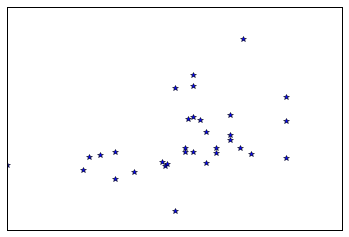

In [81]:

# see if where subjects look say anything about whether they learn or not
from sklearn import linear_model

# print h, bins
# print lookList
# print accList

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(lookList, accList)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(lookList) - accList) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(lookList, accList))

# Plot outputs
# plt.scatter(lookList, accList,  color='black')
plt.plot(accList, regr.predict(lookList), '*',color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()



In [82]:

from sklearn import svm
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
X = pca.fit_transform(lookList)
# PCA(copy=True, n_components=2, whiten=False)
print 'PCA variance ratio'
print(pca.explained_variance_ratio_) 


# split into learner/non-learners
thresh = .65

# X gotten above by PCA
# X = copy(lookList)  
y = copy( accList )
y[accList >thresh] = 1
y[accList <=thresh] = 0
print('Percent categorized as learners: %.2f' %  mean(y))

# Train SVM and look at learned model
clf = svm.SVC(kernel='linear', class_weight={1:1,0:1 })
clf.fit(X, y)
print( 'Mean accuracy: %.2f' % clf.score(X, y) )
print 'mean support vector', clf.support_vectors_.mean(axis=0)
print 'predicted values'
clf.predict( X)

# lookList
# nanmean( accList)

PCA variance ratio
[ 0.49951747  0.21091897]
Percent categorized as learners: 0.91
Mean accuracy: 0.91
mean support vector [ 0.54204978  0.31861589]
predicted values


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

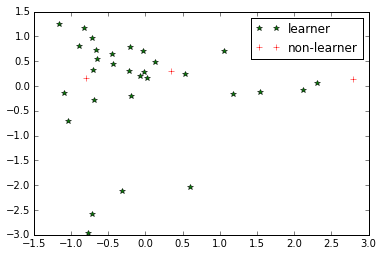

In [83]:
# figure(1)
plot( X[y==1,0], X[y==1,1], 'g*', label='learner' )
plot( X[y==0,0], X[y==0,1], 'r+', label='non-learner' )
legend()

In [84]:
# lookList

In [85]:
# clf.support_vectors_
# clf.n_support_

# print cols[:7]
# print mean( X[y==1,:], axis=0)
# print mean( X[y==0,:], axis=0)

In [86]:
# df

In [87]:
# df